# Importing neccessary Libraries

In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from scipy.stats import norm

## EDA OF STOCKS

In [6]:
plt.style.use('dark_background')
tickers = ['AAPL', 'TSLA', 'JPM', 'MCD', 'COST']  # Corrected ticker list
colors = ['cyan', 'magenta', 'yellow', 'green', 'red']  # Colors for each ticker

In [7]:
# Function to plot individual stock data
def plot_stock(ticker_symbol, color):
    t = yf.Ticker(ticker_symbol)
    hist = t.history(period="max")
    plt.figure(figsize=(14, 7))
    plt.plot(hist['Close'], color=color, label=f'{ticker_symbol} Close Price')
    plt.title(f'Historical Close Prices for {ticker_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Close Price (USD)')
    plt.legend()
    plt.grid(True, color='gray')
    plt.show()

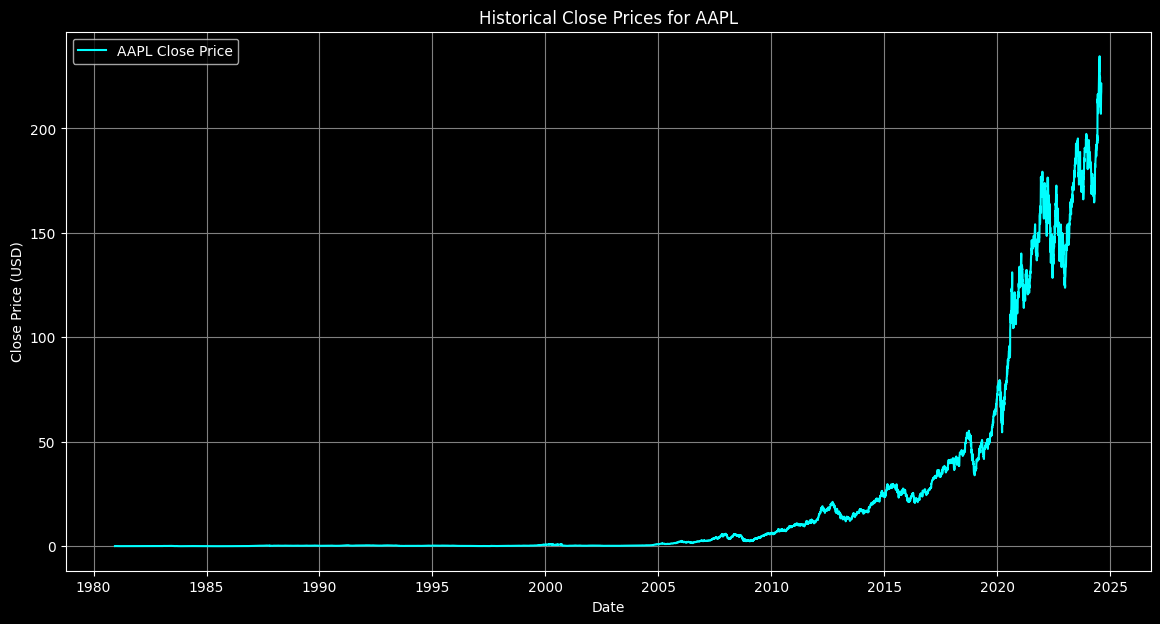

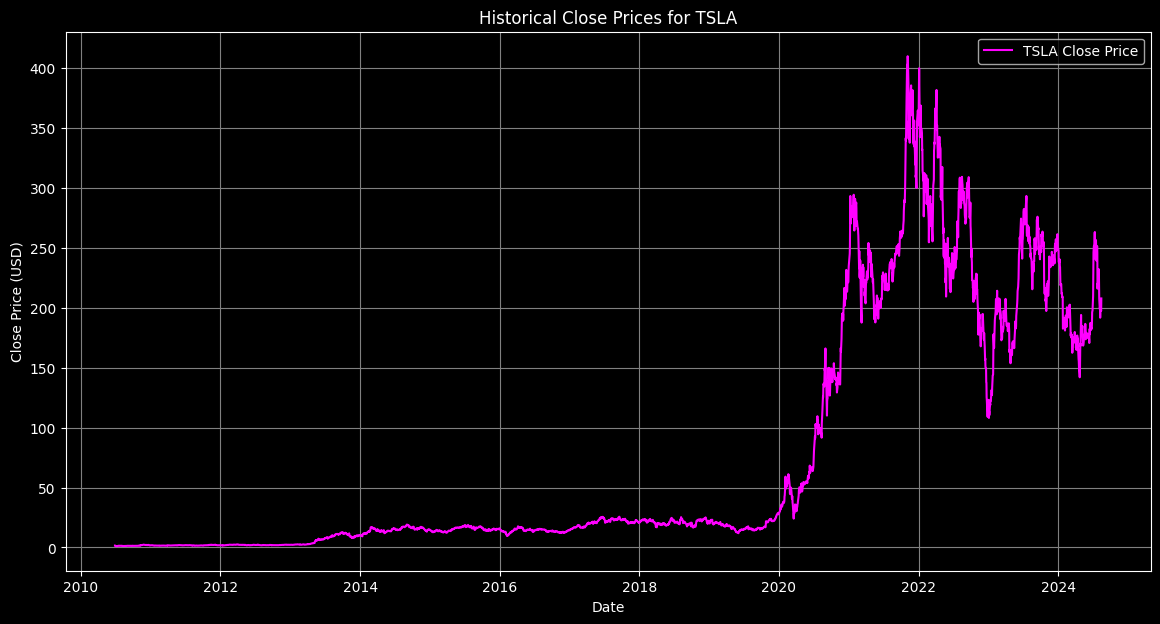

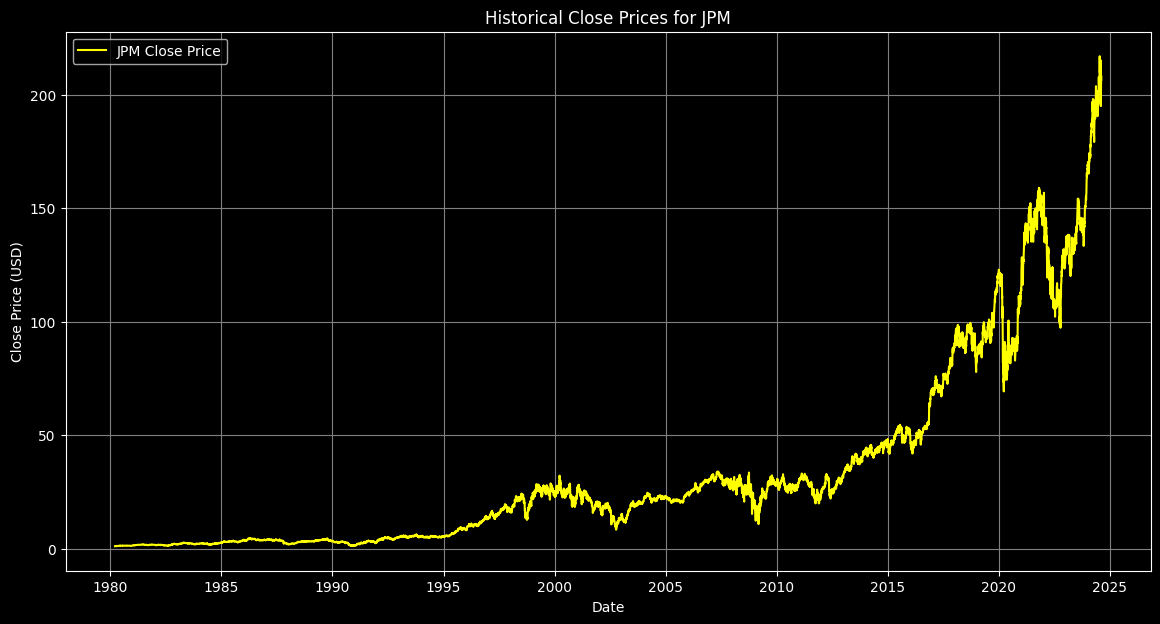

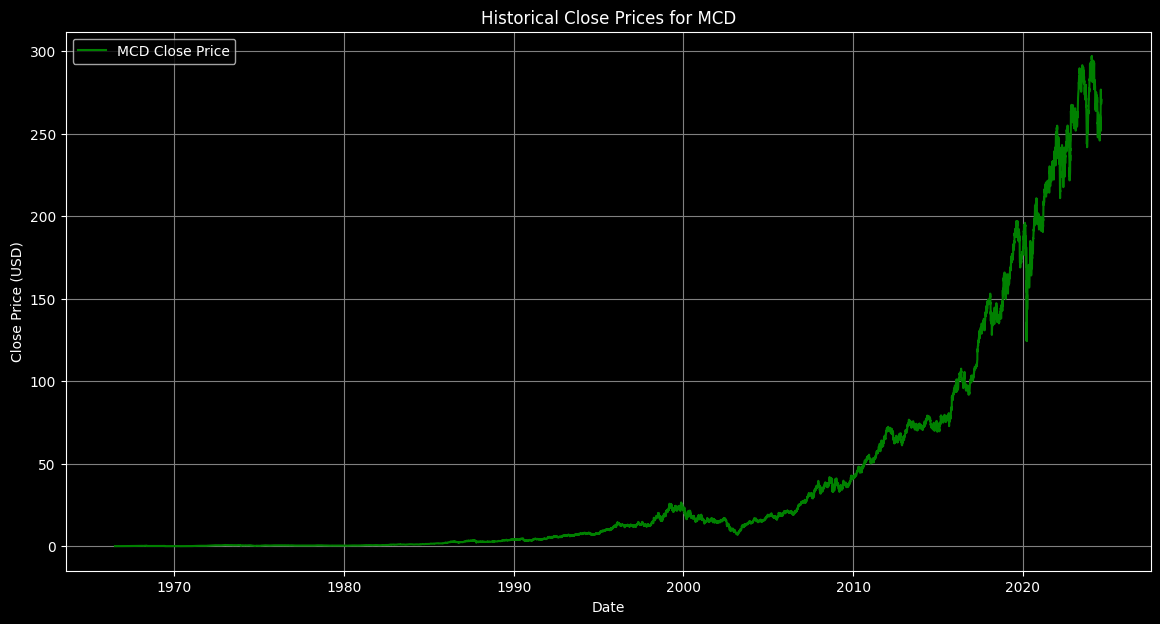

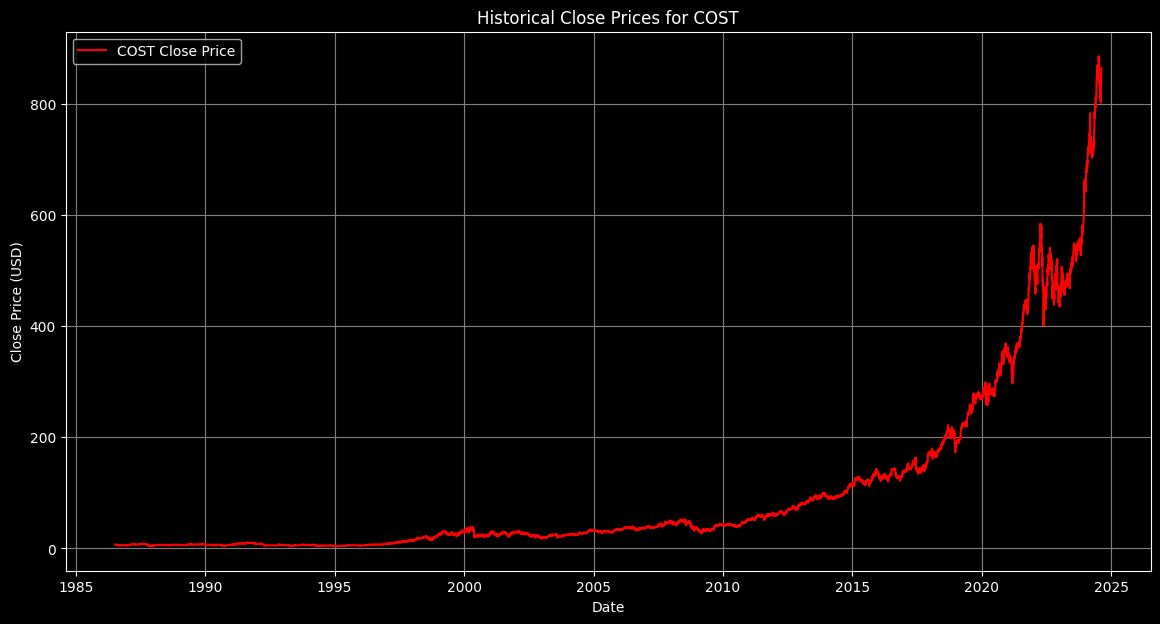

In [8]:
# Loop to plot each stock
for ticker, color in zip(tickers, colors):
    plot_stock(ticker, color)

In [9]:
# Function to fetch and process stock data
def process_stock(ticker):
    data = yf.download(ticker, start="2020-01-01", end="2024-01-01")
    data['SMA_50'] = ta.trend.sma_indicator(data['Close'], window=50)
    data['SMA_200'] = ta.trend.sma_indicator(data['Close'], window=200)
    data['RSI'] = ta.momentum.rsi(data['Close'], window=14)
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Close Price', color='lightgray')
    plt.plot(data['SMA_50'], label='50-Day SMA', color='cyan')
    plt.plot(data['SMA_200'], label='200-Day SMA', color='magenta')
    plt.title(f'Close Price and Moving Averages for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()
    plt.figure(figsize=(14, 4))
    plt.plot(data['RSI'], label='RSI', color='yellow')
    plt.axhline(70, linestyle='--', color='red', alpha=0.5)
    plt.axhline(30, linestyle='--', color='green', alpha=0.5)
    plt.title(f'RSI for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.show()


## Technical Analysis of Stocks

[*********************100%%**********************]  1 of 1 completed


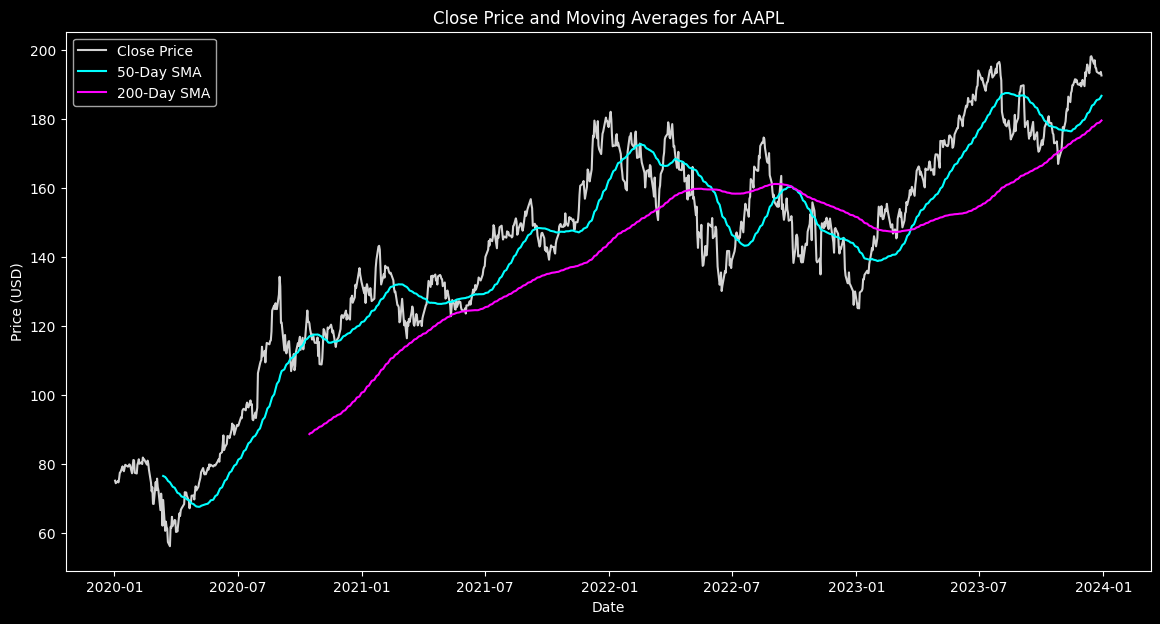

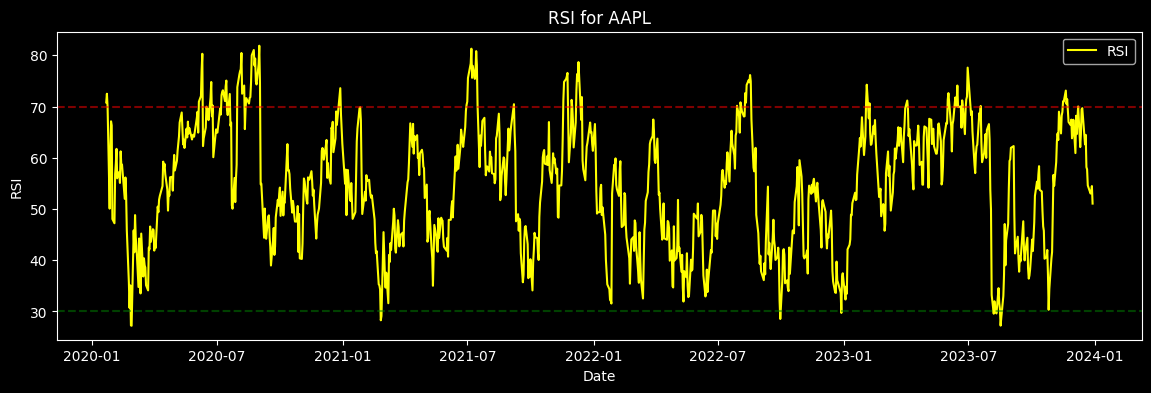

[*********************100%%**********************]  1 of 1 completed


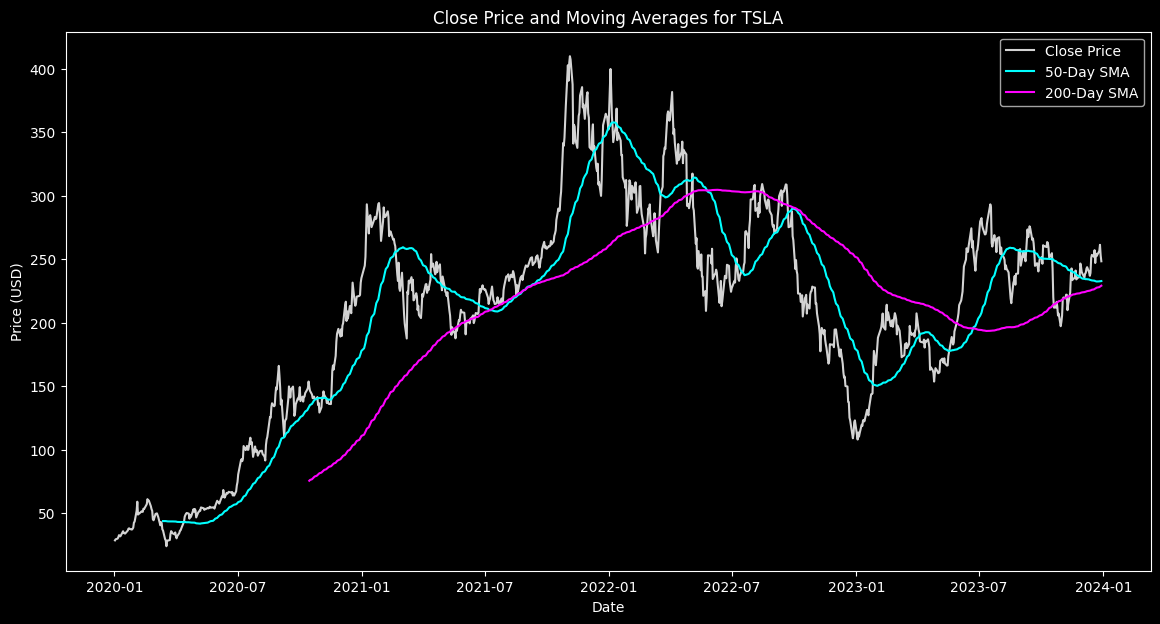

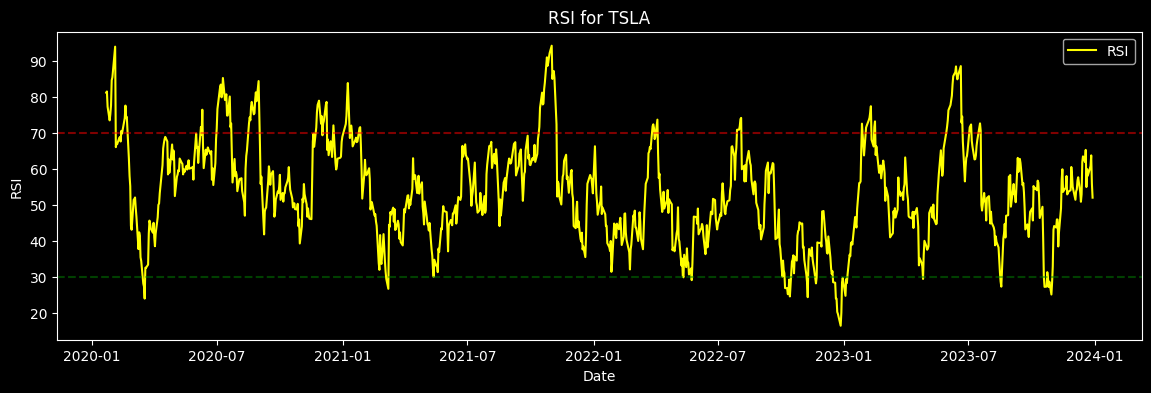

[*********************100%%**********************]  1 of 1 completed


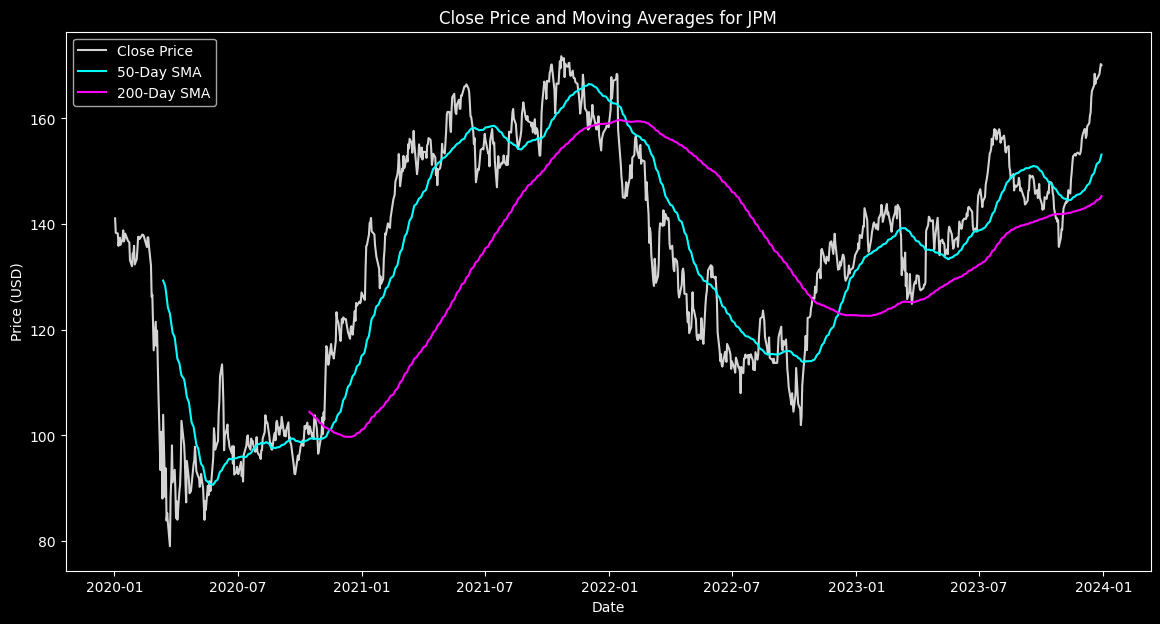

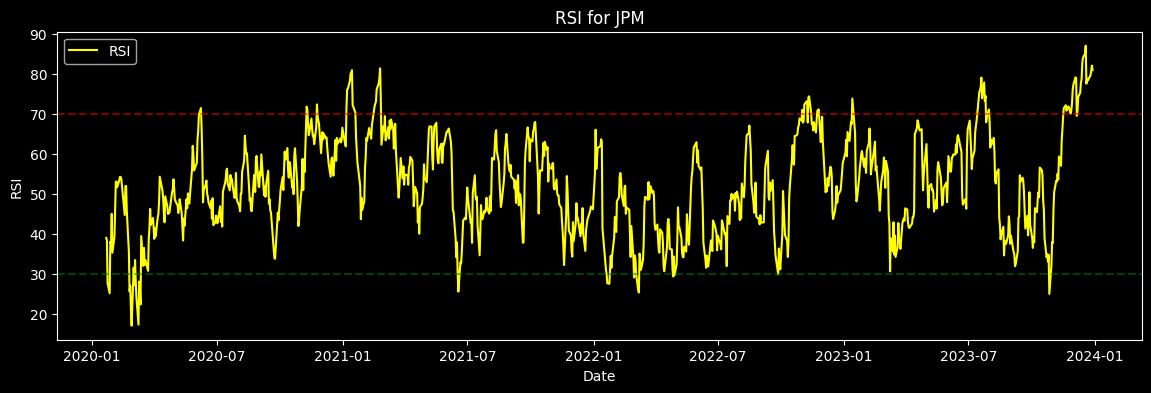

[*********************100%%**********************]  1 of 1 completed


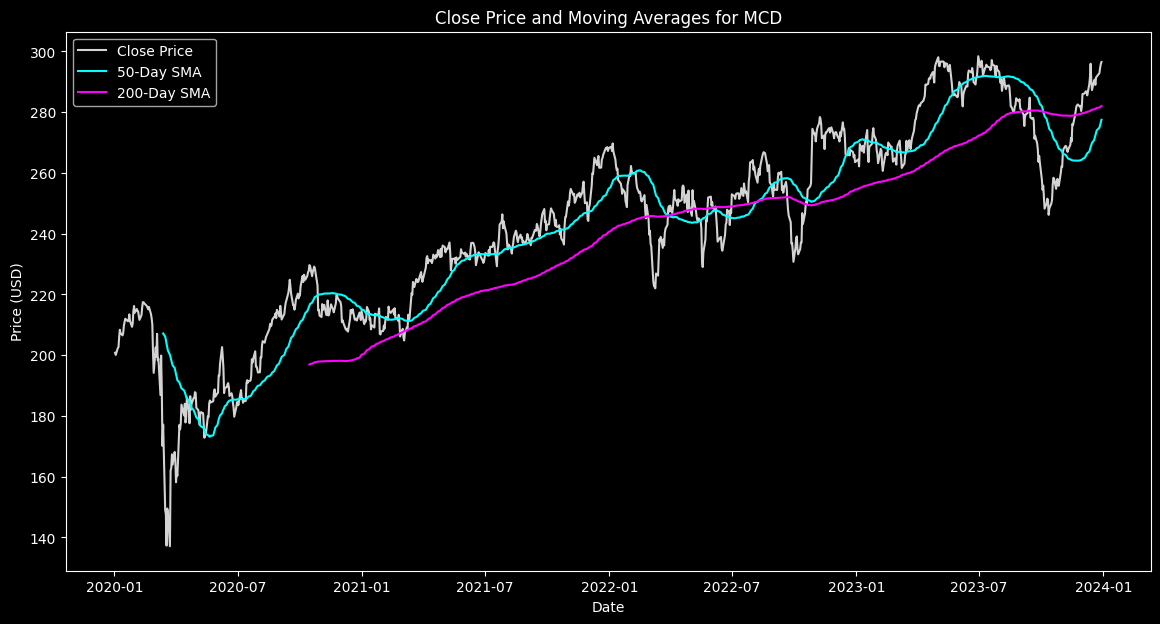

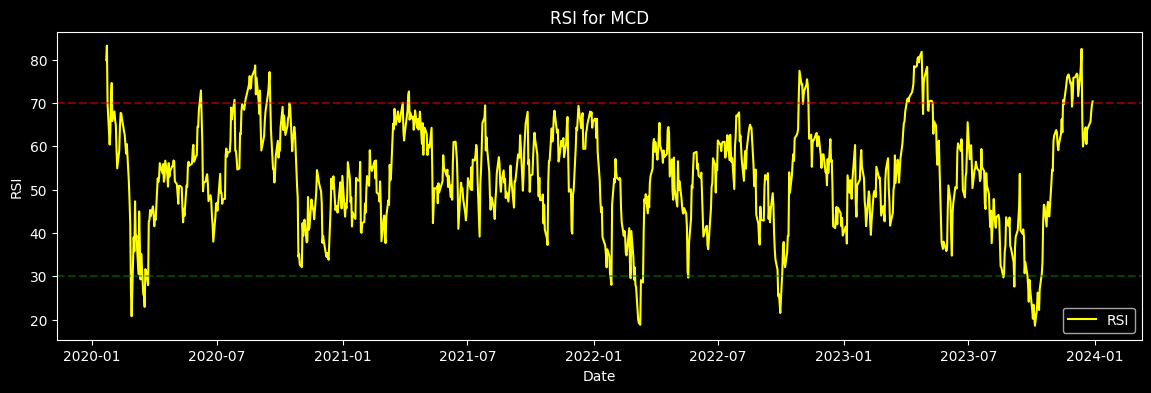

[*********************100%%**********************]  1 of 1 completed


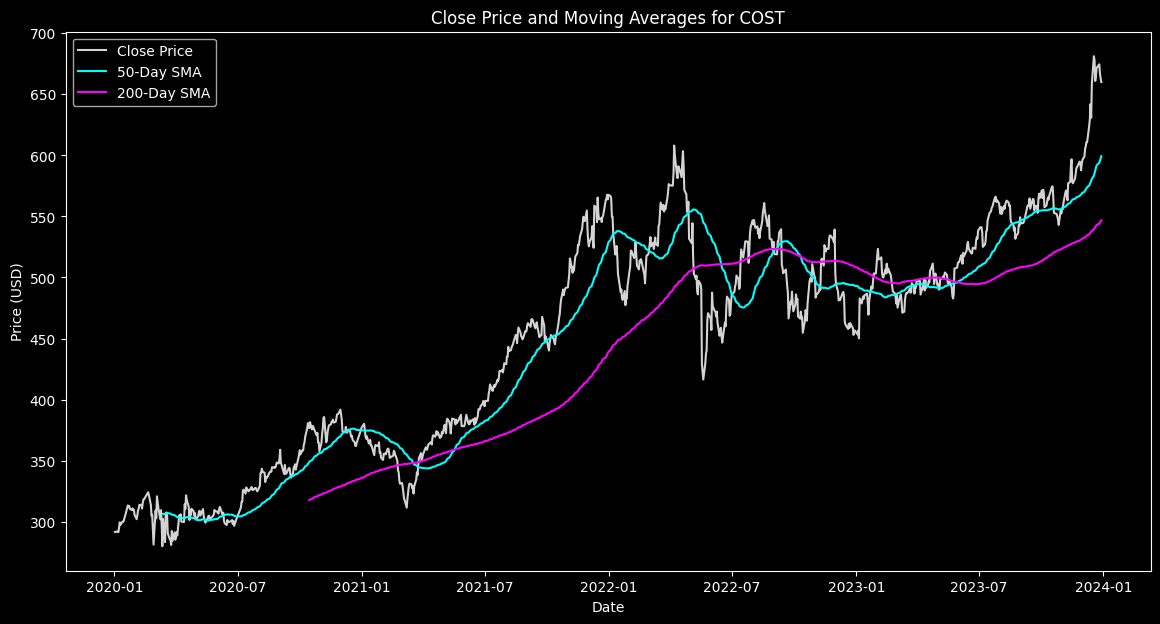

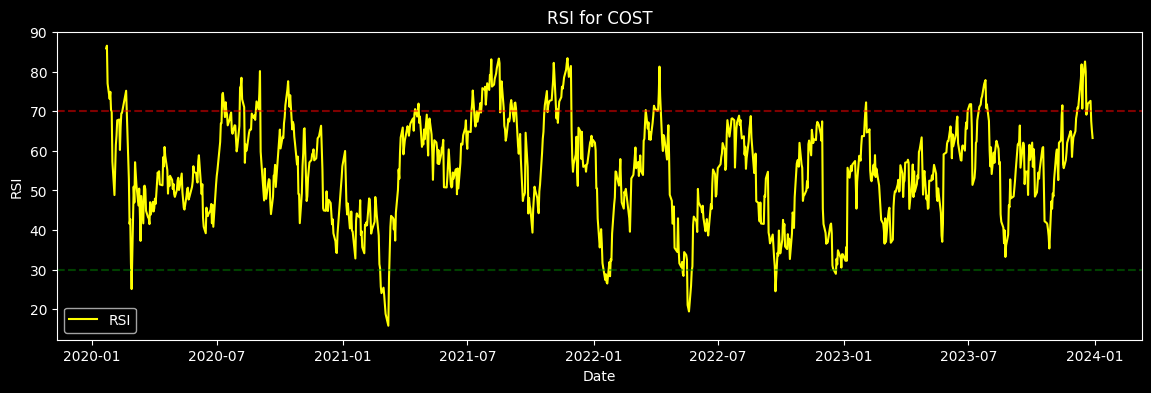

In [10]:
# Process each ticker
for ticker in tickers:
    process_stock(ticker)

In [11]:
data = yf.download(tickers, start="2019-01-01", end="2024-01-01")['Adj Close']

[*********************100%%**********************]  5 of 5 completed


In [12]:
# Calculate daily returns
daily_returns = data.pct_change()

In [13]:
# Calculate the annual returns and volatility
annual_returns = daily_returns.mean() * 252
annual_volatility = daily_returns.std() * np.sqrt(252)

In [14]:
annual_returns

Ticker
AAPL    0.378031
COST    0.280681
JPM     0.189012
MCD     0.154199
TSLA    0.708129
dtype: float64

In [15]:
annual_volatility

Ticker
AAPL    0.322345
COST    0.237449
JPM     0.318977
MCD     0.230307
TSLA    0.647000
dtype: float64

In [16]:
# Create a DataFrame for plotting
risk_return_df = pd.DataFrame({
    'Annual Returns': annual_returns,
    'Annual Volatility': annual_volatility,
    'Ticker': annual_returns.index
})

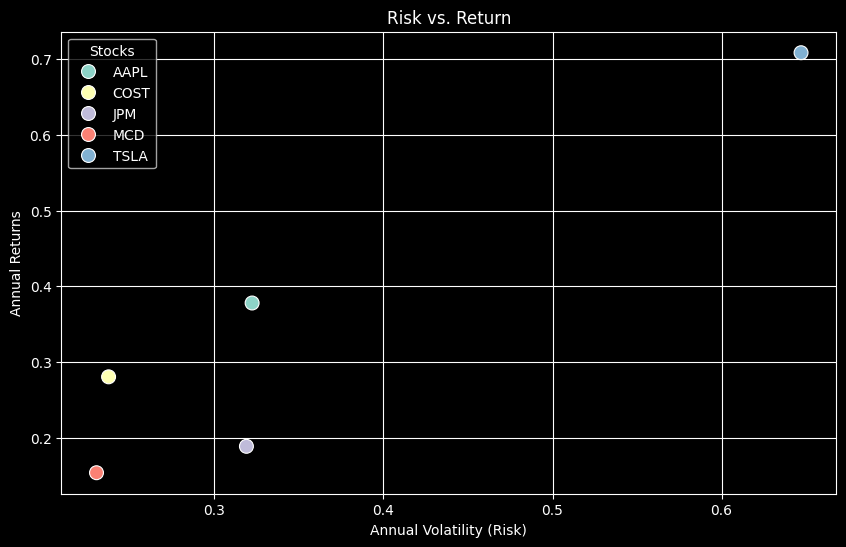

In [17]:
# Plotting risk vs return
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Volatility', y='Annual Returns', hue='Ticker', data=risk_return_df, s=100)
plt.title('Risk vs. Return')
plt.xlabel('Annual Volatility (Risk)')
plt.ylabel('Annual Returns')
plt.legend(title='Stocks')
plt.grid(True)
plt.show()

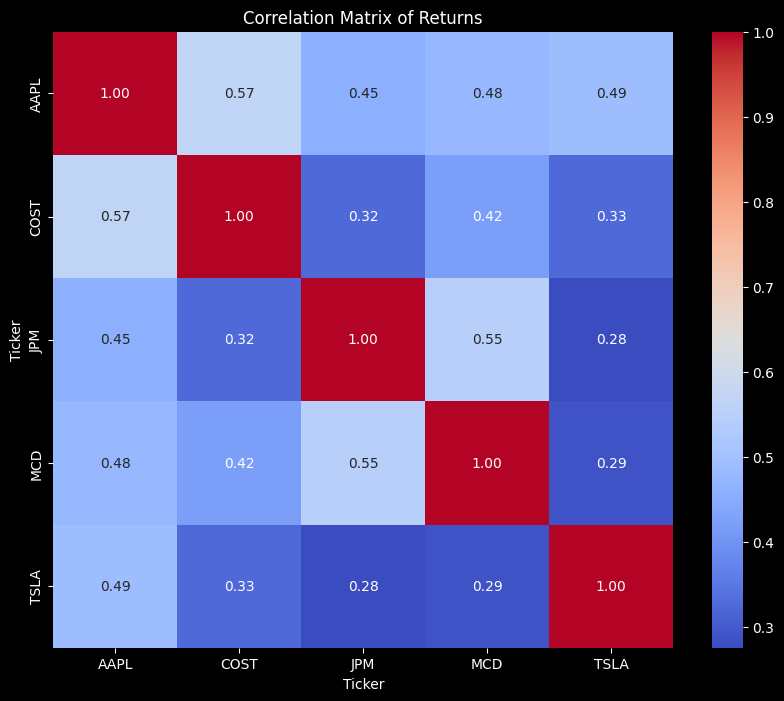

In [18]:
# Calculate the correlation matrix of returns
correlation_matrix = daily_returns.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Returns')
plt.show()

## Montecarlo simulation

In [23]:
# Log returns
log_returns = np.log(1 + data.pct_change())
log_returns

Ticker,AAPL,COST,JPM,MCD,TSLA
Date,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.104924,-0.021423,-0.014314,-0.006610,-0.031978
2019-01-04,0.041803,0.028625,0.036202,0.019141,0.056094
2019-01-07,-0.002229,0.003678,0.000695,0.010823,0.052935
2019-01-08,0.018884,0.007460,-0.001887,0.002106,0.001164
...,...,...,...,...,...
2023-12-22,-0.005563,0.009635,-0.000597,0.001063,-0.007731
2023-12-26,-0.002845,0.004487,0.005896,0.003969,0.015988
2023-12-27,0.000518,0.010826,0.005980,0.005754,0.018647


In [24]:
# Setup for Monte Carlo parameters
t_intervals = 252 * 2  # Number of trading days in 2 years
iterations = 50  # Number of simulation iterations

In [25]:
# Prepare for simulation for each stock
simulations = {}
for ticker in tickers:
    # Calculate drift and volatility
    u = log_returns[ticker].mean()  # Mean of log returns
    var = log_returns[ticker].var()  # Variance of log returns
    drift = u - (0.5 * var)
    stdev = log_returns[ticker].std()

In [28]:
# Daily returns
daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iterations)))

In [29]:
# Last stock price
S0 = data[ticker].iloc[-1]

In [30]:
# Create a price list array
price_list = np.zeros_like(daily_returns)
price_list[0] = S0

In [31]:
# Generate stock prices for each day
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]

simulations[ticker] = price_list


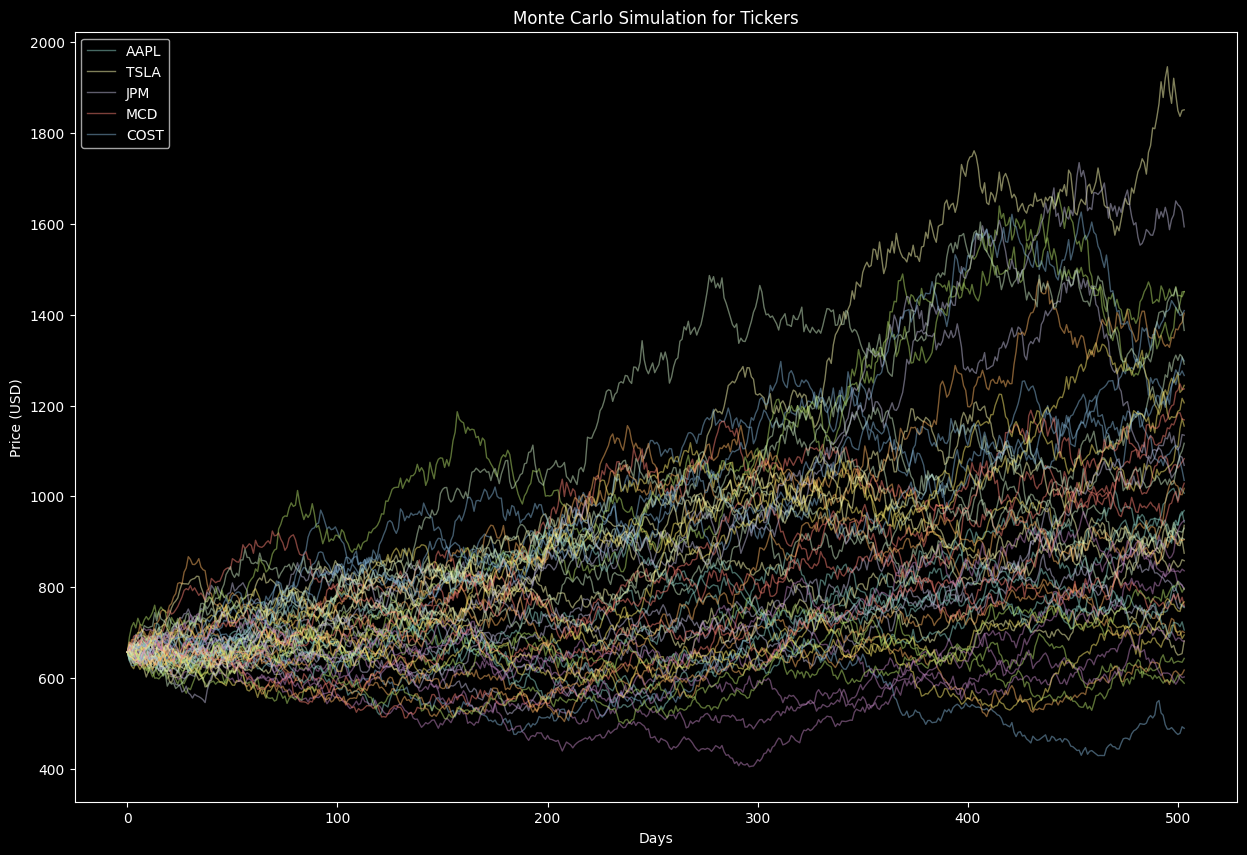

In [62]:
plt.figure(figsize=(15, 10))
for ticker, simulation in simulations.items():
    plt.plot(simulation, lw=1, alpha=0.5)
    plt.title(f'Monte Carlo Simulation for Tickers')
    plt.xlabel('Days')
    plt.ylabel('Price (USD)')
plt.legend(tickers)
plt.show()


## Quantitative Analysis - Calculating Financial Ratios

In [61]:
# Initialize DataFrame to store all the financial ratios
all_ratios = pd.DataFrame()

for ticker in tickers:
    # Fetch historical data and financials
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")
    financials = stock.financials
    balance_sheet = stock.balance_sheet

    # Get latest closing price and earnings per share
    market_price = hist['Close'].iloc[-1]
    eps = stock.info.get('trailingEps', np.nan)  # Safe access to 'trailingEps'

    # Extract financial figures
    net_income = financials.loc['Net Income'].iloc[0] if 'Net Income' in financials.index else np.nan
    total_assets = balance_sheet.loc['Total Assets'].iloc[0] if 'Total Assets' in balance_sheet.index else np.nan
    current_liabilities = balance_sheet.loc['Current Liabilities'].iloc[0] if 'Current Liabilities' in balance_sheet.index else np.nan
    non_current_liabilities = balance_sheet.loc['Total Non Current Liabilities Net Minority Interest'].iloc[0] if 'Total Non Current Liabilities Net Minority Interest' in balance_sheet.index else np.nan

    # Calculate total liabilities
    total_liabilities = np.nan if np.isnan(current_liabilities) or np.isnan(non_current_liabilities) else current_liabilities + non_current_liabilities

    shareholders_equity = balance_sheet.loc['Stockholders Equity'].iloc[0] if 'Stockholders Equity' in balance_sheet.index else np.nan

    # Calculate financial ratios
    pe_ratio = market_price / eps if eps and market_price else np.nan
    roa = net_income / total_assets if net_income and total_assets else np.nan
    de_ratio = total_liabilities / shareholders_equity if total_liabilities and shareholders_equity else np.nan

    # Append the results to the DataFrame
    ratios = pd.DataFrame({
        'Ticker': [ticker],
        'P/E Ratio': [pe_ratio],
        'ROA': [roa],
        'D/E Ratio': [de_ratio]
    })

    all_ratios = pd.concat([all_ratios, ratios], ignore_index=True)

# Display all calculated ratios
print("Financial Ratios for All Tickers:")
print(all_ratios)


Financial Ratios for All Tickers:
  Ticker  P/E Ratio       ROA  D/E Ratio
0   AAPL  33.678844  0.275098   4.673462
1   TSLA  58.543662  0.140680   0.686672
2    JPM  11.584401  0.012786        NaN
3    MCD  23.690622  0.150833 -12.929122
4   COST  53.482994  0.091196   1.753372
